In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import os


In [2]:
# Define base paths
data_dir = "../../data/loaded"
Images_dir = "../../images/processing_1"
processed_data_dir = "../../data/processed"
soil_file_path = os.path.join(data_dir, "soil.csv")
landcover_file_path = os.path.join(data_dir, "landcover.csv")

In [3]:
soil_df = pd.read_csv(soil_file_path)
landcover_df = pd.read_csv(landcover_file_path)

## check overlay

In [4]:
# use wkt for landcover gemotry
from shapely import wkt
landcover_df['geometry'] = landcover_df['geometry'].apply(wkt.loads)

In [5]:
landcover_gdf = gpd.GeoDataFrame(landcover_df, geometry='geometry', crs='EPSG:4326')

In [6]:
# keep only soil points that are within landcover geometries
soil_gdf = gpd.GeoDataFrame(soil_df, geometry=gpd.points_from_xy(soil_df.longitude, soil_df.latitude), crs='EPSG:4326')
print(soil_gdf.head())

   longitude   latitude  HWSD2_SMU_ID LAYER  COARSE  SAND  SILT  CLAY  \
0  -8.670833  37.545833         65535   NaN     NaN   NaN   NaN   NaN   
1  -8.662500  37.545833         65535   NaN     NaN   NaN   NaN   NaN   
2  -8.654167  37.545833         65535   NaN     NaN   NaN   NaN   NaN   
3  -8.645833  37.545833         65535   NaN     NaN   NaN   NaN   NaN   
4  -8.637500  37.545833         65535   NaN     NaN   NaN   NaN   NaN   

   TEXTURE_USDA TEXTURE_SOTER  ...  CEC_CLAY  CEC_EFF  TEB  BSAT  ALUM_SAT  \
0           NaN           NaN  ...       NaN      NaN  NaN   NaN       NaN   
1           NaN           NaN  ...       NaN      NaN  NaN   NaN       NaN   
2           NaN           NaN  ...       NaN      NaN  NaN   NaN       NaN   
3           NaN           NaN  ...       NaN      NaN  NaN   NaN       NaN   
4           NaN           NaN  ...       NaN      NaN  NaN   NaN       NaN   

   ESP  TCARBON_EQ  GYPSUM  ELEC_COND                   geometry  
0  NaN         NaN     Na

In [7]:
# Spatial join: keep only soil points within land polygons
soil_in_land = gpd.sjoin(
    soil_gdf,
    landcover_gdf,
    how='inner',
    predicate='within'
)

# Reset index
soil_in_land = soil_in_land.reset_index(drop=True)

In [8]:
# soil_in_land.plot()
# plt.show()

In [8]:
# turn back to dataframe and keep only original soil columns
soil_in_land_df = pd.DataFrame(soil_in_land[soil_df.columns])
print(soil_in_land_df.head())

   longitude   latitude  HWSD2_SMU_ID LAYER  COARSE  SAND  SILT  CLAY  \
0   8.937500  37.537500         31802    D1    11.0  40.0  41.0  19.0   
1   8.937500  37.537500         31802    D1     9.0  25.0  53.0  22.0   
2   8.945833  37.537500         31805    D1     9.0  87.0   9.0   4.0   
3   8.945833  37.537500         31805    D1     5.0  33.0  31.0  36.0   
4   8.912500  37.529167         31802    D1    11.0  40.0  41.0  19.0   

   TEXTURE_USDA TEXTURE_SOTER  ...  CEC_SOIL  CEC_CLAY  CEC_EFF   TEB  BSAT  \
0           9.0             M  ...      11.0      26.0      6.0   5.0  47.0   
1           7.0             M  ...      15.0      51.0     14.0  12.0  65.0   
2          12.0             C  ...       4.0      33.0      3.0   3.0  76.0   
3           5.0             F  ...      20.0      34.0     15.0  17.0  82.0   
4           9.0             M  ...      11.0      26.0      6.0   5.0  47.0   

   ALUM_SAT  ESP  TCARBON_EQ  GYPSUM  ELEC_COND  
0      21.0  1.0         0.0     0.1

In [9]:
print(f"Original soil data shape: {soil_df.shape}")
print(f"Filtered soil data shape: {soil_in_land_df.shape}")
print(f"Number of soil points removed: {soil_df.shape[0] - soil_in_land_df.shape[0]}")
print(f"Percentage of soil points removed: {((soil_df.shape[0] - soil_in_land_df.shape[0]) / soil_df.shape[0]) * 100:.2f}%")


Original soil data shape: (9352670, 26)
Filtered soil data shape: (7113954, 26)
Number of soil points removed: 2238716
Percentage of soil points removed: 23.94%


In [12]:
# check duplicated longitude and latitude before and after spatial join
original_duplicated_soil_points = soil_df[soil_df.duplicated(subset=['longitude', 'latitude'], keep=False)]
print(f"Number of duplicated soil points in original data: {len(original_duplicated_soil_points)}")
duplicated_soil_points = soil_in_land_df[soil_in_land_df.duplicated(subset=['longitude', 'latitude'], keep=False)]
print(f"Number of duplicated soil points after spatial join: {len(duplicated_soil_points)}")

Number of duplicated soil points in original data: 6080704
Number of duplicated soil points after spatial join: 6080704


## Drop cols

In [12]:
# drop  HWSD2_SMU_ID and LAYER 
soil_in_land_df = soil_in_land_df.drop(columns=['HWSD2_SMU_ID', 'LAYER'])
print(soil_in_land_df.head())

   longitude   latitude  COARSE  SAND  SILT  CLAY  TEXTURE_USDA TEXTURE_SOTER  \
0   8.937500  37.537500    11.0  40.0  41.0  19.0           9.0             M   
1   8.937500  37.537500     9.0  25.0  53.0  22.0           7.0             M   
2   8.945833  37.537500     9.0  87.0   9.0   4.0          12.0             C   
3   8.945833  37.537500     5.0  33.0  31.0  36.0           5.0             F   
4   8.912500  37.529167    11.0  40.0  41.0  19.0           9.0             M   

   BULK  REF_BULK  ...  CEC_SOIL  CEC_CLAY  CEC_EFF   TEB  BSAT  ALUM_SAT  \
0  1.47      1.69  ...      11.0      26.0      6.0   5.0  47.0      21.0   
1  1.46      1.73  ...      15.0      51.0     14.0  12.0  65.0      26.0   
2  1.44      1.20  ...       4.0      33.0      3.0   3.0  76.0       6.0   
3  1.35      1.90  ...      20.0      34.0     15.0  17.0  82.0       0.0   
4  1.47      1.69  ...      11.0      26.0      6.0   5.0  47.0      21.0   

   ESP  TCARBON_EQ  GYPSUM  ELEC_COND  
0  1.0    

# handeling missing values

In [12]:
soil_in_land_df.isna().sum()

longitude              0
latitude               0
COARSE               418
SAND                 418
SILT                 418
CLAY                 418
TEXTURE_USDA     1339950
TEXTURE_SOTER        418
BULK                 418
REF_BULK         1339950
ORG_CARBON           418
PH_WATER             418
TOTAL_N              418
CN_RATIO             418
CEC_SOIL             418
CEC_CLAY             418
CEC_EFF              418
TEB                  418
BSAT                 418
ALUM_SAT             418
ESP                  418
TCARBON_EQ           418
GYPSUM               418
ELEC_COND            418
dtype: int64

first let's turn negative and "-" value to nan

In [13]:
# fill rows SILT negative with nan in all columns except longitude and latitude in a new dataframe
soil_in_land_df_nan = soil_in_land_df.copy()
soil_in_land_df_nan.loc[soil_in_land_df_nan['SILT'] < 0, soil_in_land_df_nan.columns.difference(['longitude', 'latitude'])] = np.nan
print(soil_in_land_df_nan.isna().sum())

longitude              0
latitude               0
COARSE           1339950
SAND             1339950
SILT             1339950
CLAY             1339950
TEXTURE_USDA     1339950
TEXTURE_SOTER    1339950
BULK             1339950
REF_BULK         1339950
ORG_CARBON       1339950
PH_WATER         1339950
TOTAL_N          1339950
CN_RATIO         1339950
CEC_SOIL         1339950
CEC_CLAY         1339950
CEC_EFF          1339950
TEB              1339950
BSAT             1339950
ALUM_SAT         1339950
ESP              1339950
TCARBON_EQ       1339950
GYPSUM           1339950
ELEC_COND        1339950
dtype: int64


In [14]:
soil_in_land_nan_gdf = gpd.GeoDataFrame(soil_in_land_df_nan, geometry=gpd.points_from_xy(soil_in_land_df_nan.longitude, soil_in_land_df_nan.latitude), crs='EPSG:4326')

In [ ]:
# # save soil_in_land_df temporarily
# soil_in_land_df_nan.to_csv(os.path.join(processed_data_dir, 'soil_in_land_temp.csv'), index=False)

### filling missing values

In [ ]:
'''
strategy for filling missing values:
- first get the min distance to eah nighbor for each missing point
    - start with the point with min distance
    - take median/mean for num, and mode for cat
'''


In [17]:
import numpy as np
from scipy.spatial import cKDTree
from collections import Counter

def fill_missing_by_nearest_priority(soil_gdf, numeric_cols=[], categorical_cols=[], k=5):
    """
    Optimized missing value imputation prioritized by minimum distance to nearest neighbor.
    Points with smallest distance to ANY non-missing neighbor get imputed first.
    
    Super optimized for large datasets:
    - Single KDTree rebuild per batch of completed points
    - Vectorized distance calculations
    - Minimal memory allocation
    """
    soil_gdf = soil_gdf.copy()
    coords = np.array(list(zip(soil_gdf.geometry.x, soil_gdf.geometry.y)))
    
    all_cols = numeric_cols + categorical_cols
    missing_mask = soil_gdf[all_cols].isna().any(axis=1).values
    
    missing_idx = np.where(missing_mask)[0]
    if len(missing_idx) == 0:
        return soil_gdf
    
    non_missing_idx = np.where(~missing_mask)[0]
    if len(non_missing_idx) == 0:
        raise ValueError("No non-missing points to use for filling!")
    
    # Build initial tree
    tree = cKDTree(coords[non_missing_idx])
    
    # Get MINIMUM distance (distance to nearest neighbor) for each missing point
    min_distances, _ = tree.query(coords[missing_idx], k=1)
    
    # Sort by minimum distance (ascending)
    priority_order = np.argsort(min_distances)
    sorted_missing_idx = missing_idx[priority_order]
    
    # Pre-allocate for batch processing
    batch_size = 1000
    num_batches = (len(sorted_missing_idx) + batch_size - 1) // batch_size
    
    print(f"Starting imputation: {len(sorted_missing_idx)} points in {num_batches} batches")
    
    available_mask = ~missing_mask.copy()
    available_idx = non_missing_idx.copy()
    
    for batch_i in range(num_batches):
        start = batch_i * batch_size
        end = min(start + batch_size, len(sorted_missing_idx))
        batch_indices = sorted_missing_idx[start:end]
        
        # Query k neighbors for entire batch at once
        actual_k = min(k, len(available_idx))
        _, indices = tree.query(coords[batch_indices], k=actual_k)
        
        if actual_k == 1:
            indices = indices.reshape(-1, 1)
        
        # Impute each point in batch
        for local_i, miss_i in enumerate(batch_indices):
            neighbor_indices = available_idx[indices[local_i]]
            
            # Numeric: median
            for col in numeric_cols:
                if pd.isna(soil_gdf.iat[miss_i, soil_gdf.columns.get_loc(col)]):
                    vals = soil_gdf.iloc[neighbor_indices][col].dropna().values
                    if len(vals) > 0:
                        soil_gdf.iat[miss_i, soil_gdf.columns.get_loc(col)] = np.median(vals)
            
            # Categorical: mode
            for col in categorical_cols:
                if pd.isna(soil_gdf.iat[miss_i, soil_gdf.columns.get_loc(col)]):
                    vals = soil_gdf.iloc[neighbor_indices][col].dropna().values
                    if len(vals) > 0:
                        soil_gdf.iat[miss_i, soil_gdf.columns.get_loc(col)] = Counter(vals).most_common(1)[0][0]
            
            available_mask[miss_i] = True
        
        # Progress update
        completed = end
        print(f"  Progress: {completed}/{len(sorted_missing_idx)} points ({100*completed//len(sorted_missing_idx)}%)")
        
        # Rebuild tree only after completing batch
        if end < len(sorted_missing_idx):
            available_idx = np.where(available_mask)[0]
            tree = cKDTree(coords[available_idx])
    
    print(f"✓ Completed: All {len(sorted_missing_idx)} points imputed")
    return soil_gdf

In [18]:
categorical_cols = ['TEXTURE_USDA', 'TEXTURE_SOTER']
numerical_cols = [
    'COARSE', 'SAND', 'SILT', 'CLAY', 'BULK', 'REF_BULK', 'ORG_CARBON',
    'PH_WATER', 'TOTAL_N', 'CN_RATIO', 'CEC_SOIL', 'CEC_CLAY', 'CEC_EFF',
    'TEB', 'BSAT', 'ALUM_SAT', 'ESP', 'TCARBON_EQ', 'GYPSUM', 'ELEC_COND'
]

soil_filled = fill_missing_by_nearest_priority(soil_in_land_nan_gdf, numerical_cols, categorical_cols)


Starting imputation: 1339950 points in 1340 batches
  Progress: 1000/1339950 points (0%)
  Progress: 2000/1339950 points (0%)
  Progress: 3000/1339950 points (0%)
  Progress: 4000/1339950 points (0%)
  Progress: 5000/1339950 points (0%)
  Progress: 6000/1339950 points (0%)
  Progress: 7000/1339950 points (0%)
  Progress: 8000/1339950 points (0%)
  Progress: 9000/1339950 points (0%)
  Progress: 10000/1339950 points (0%)
  Progress: 11000/1339950 points (0%)
  Progress: 12000/1339950 points (0%)
  Progress: 13000/1339950 points (0%)
  Progress: 14000/1339950 points (1%)
  Progress: 15000/1339950 points (1%)
  Progress: 16000/1339950 points (1%)
  Progress: 17000/1339950 points (1%)
  Progress: 18000/1339950 points (1%)
  Progress: 19000/1339950 points (1%)
  Progress: 20000/1339950 points (1%)
  Progress: 21000/1339950 points (1%)
  Progress: 22000/1339950 points (1%)
  Progress: 23000/1339950 points (1%)
  Progress: 24000/1339950 points (1%)
  Progress: 25000/1339950 points (1%)
  Progr

In [19]:
soil_filled.to_csv(os.path.join(processed_data_dir, 'soil_filled_min.csv'), index=False)

In [20]:
import numpy as np
from scipy.spatial import cKDTree
from collections import Counter

def fill_missing_by_average_distance(soil_gdf, numeric_cols=[], categorical_cols=[], k=5):
    """
    Optimized imputation prioritized by AVERAGE distance to k nearest neighbors.
    Points well-surrounded by non-missing data get imputed first (more robust).
    """
    soil_gdf = soil_gdf.copy()
    coords = np.array(list(zip(soil_gdf.geometry.x, soil_gdf.geometry.y)))
    
    all_cols = numeric_cols + categorical_cols
    missing_mask = soil_gdf[all_cols].isna().any(axis=1).values
    
    missing_idx = np.where(missing_mask)[0]
    if len(missing_idx) == 0:
        return soil_gdf
    
    non_missing_idx = np.where(~missing_mask)[0]
    if len(non_missing_idx) == 0:
        raise ValueError("No non-missing points to use for filling!")
    
    # Build initial tree
    tree = cKDTree(coords[non_missing_idx])
    
    # Get AVERAGE distance across k nearest neighbors
    actual_k = min(k, len(non_missing_idx))
    distances, _ = tree.query(coords[missing_idx], k=actual_k)
    
    # Calculate average distance
    if actual_k == 1:
        avg_distances = distances
    else:
        avg_distances = distances.mean(axis=1)
    
    # Sort by average distance (ascending)
    priority_order = np.argsort(avg_distances)
    sorted_missing_idx = missing_idx[priority_order]
    
    # Batch processing
    batch_size = 100
    num_batches = (len(sorted_missing_idx) + batch_size - 1) // batch_size
    
    print(f"Starting imputation (AVG method): {len(sorted_missing_idx)} points in {num_batches} batches")
    
    available_mask = ~missing_mask.copy()
    available_idx = non_missing_idx.copy()
    
    for batch_i in range(num_batches):
        start = batch_i * batch_size
        end = min(start + batch_size, len(sorted_missing_idx))
        batch_indices = sorted_missing_idx[start:end]
        
        actual_k = min(k, len(available_idx))
        _, indices = tree.query(coords[batch_indices], k=actual_k)
        
        if actual_k == 1:
            indices = indices.reshape(-1, 1)
        
        for local_i, miss_i in enumerate(batch_indices):
            neighbor_indices = available_idx[indices[local_i]]
            
            for col in numeric_cols:
                if pd.isna(soil_gdf.iat[miss_i, soil_gdf.columns.get_loc(col)]):
                    vals = soil_gdf.iloc[neighbor_indices][col].dropna().values
                    if len(vals) > 0:
                        soil_gdf.iat[miss_i, soil_gdf.columns.get_loc(col)] = np.median(vals)
            
            for col in categorical_cols:
                if pd.isna(soil_gdf.iat[miss_i, soil_gdf.columns.get_loc(col)]):
                    vals = soil_gdf.iloc[neighbor_indices][col].dropna().values
                    if len(vals) > 0:
                        soil_gdf.iat[miss_i, soil_gdf.columns.get_loc(col)] = Counter(vals).most_common(1)[0][0]
            
            available_mask[miss_i] = True
        
        completed = end
        print(f"  Progress: {completed}/{len(sorted_missing_idx)} points ({100*completed//len(sorted_missing_idx)}%)")
        
        if end < len(sorted_missing_idx):
            available_idx = np.where(available_mask)[0]
            tree = cKDTree(coords[available_idx])
    
    print(f"✓ Completed: All {len(sorted_missing_idx)} points imputed")
    return soil_gdf

In [21]:
categorical_cols = ['TEXTURE_USDA', 'TEXTURE_SOTER']
numerical_cols = [
    'COARSE', 'SAND', 'SILT', 'CLAY', 'BULK', 'REF_BULK', 'ORG_CARBON',
    'PH_WATER', 'TOTAL_N', 'CN_RATIO', 'CEC_SOIL', 'CEC_CLAY', 'CEC_EFF',
    'TEB', 'BSAT', 'ALUM_SAT', 'ESP', 'TCARBON_EQ', 'GYPSUM', 'ELEC_COND'
]

soil_filled = fill_missing_by_average_distance(soil_in_land_nan_gdf, numerical_cols, categorical_cols)
soil_filled.to_csv(os.path.join(processed_data_dir, 'soil_filled_avg.csv'), index=False)

Starting imputation (AVG method): 1339950 points in 13400 batches
  Progress: 100/1339950 points (0%)
  Progress: 200/1339950 points (0%)
  Progress: 300/1339950 points (0%)
  Progress: 400/1339950 points (0%)
  Progress: 500/1339950 points (0%)
  Progress: 600/1339950 points (0%)
  Progress: 700/1339950 points (0%)
  Progress: 800/1339950 points (0%)
  Progress: 900/1339950 points (0%)
  Progress: 1000/1339950 points (0%)
  Progress: 1100/1339950 points (0%)
  Progress: 1200/1339950 points (0%)
  Progress: 1300/1339950 points (0%)
  Progress: 1400/1339950 points (0%)
  Progress: 1500/1339950 points (0%)
  Progress: 1600/1339950 points (0%)
  Progress: 1700/1339950 points (0%)
  Progress: 1800/1339950 points (0%)
  Progress: 1900/1339950 points (0%)
  Progress: 2000/1339950 points (0%)
  Progress: 2100/1339950 points (0%)
  Progress: 2200/1339950 points (0%)
  Progress: 2300/1339950 points (0%)
  Progress: 2400/1339950 points (0%)
  Progress: 2500/1339950 points (0%)
  Progress: 2600/1

In [ ]:
print(soil_filled.isna().sum())

## compare distributions

In [16]:
# read soil_filled_min.csv and soil_filled_avg.csv and compare the number of missing values
soil_filled_min = pd.read_csv(os.path.join(processed_data_dir, 'soil_filled_min.csv'))
soil_filled_avg = pd.read_csv(os.path.join(processed_data_dir, 'soil_filled_avg.csv'))

In [17]:
print("Missing values in soil_filled_min.csv:")
print(soil_filled_min.isna().sum().sum())
print("Missing values in soil_filled_avg.csv:")
print(soil_filled_avg.isna().sum().sum())

Missing values in soil_filled_min.csv:
0
Missing values in soil_filled_avg.csv:
0


In [19]:
# save soil_in_land_nan dataframe
soil_in_land_df_nan.to_csv(os.path.join(processed_data_dir, 'soil_in_land_nan.csv'), index=False)

In [3]:
# read soil_filled_min.csv and soil_filled_avg.csv and soil_in_land_nan.csv
soil_filled_min = pd.read_csv(os.path.join(processed_data_dir, 'soil_filled_min.csv'))
soil_filled_avg = pd.read_csv(os.path.join(processed_data_dir, 'soil_filled_avg.csv'))
soil_in_land_nan = pd.read_csv(os.path.join(processed_data_dir, 'soil_in_land_nan.csv'))

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import numpy as np

def compare_soil_distributions(dfs, cols=None, sample_size=50000, save_path=None):
    """
    Compare multiple soil datasets.
    
    Parameters:
    - dfs: list of tuples (name, dataframe, color)
    - cols: list of columns to plot (default: all columns from first dataframe)
    - sample_size: max number of points to plot per dataset per column
    - save_path: file path to save figure (optional)
    """
    if cols is None:
        cols = dfs[0][1].columns
    
    for col in cols:
        plt.figure(figsize=(8, 4))
        
        for name, df, color in dfs:
            # Sample to reduce memory usage
            if df.shape[0] > sample_size:
                df_sample = df.sample(sample_size, random_state=0)
            else:
                df_sample = df
            
            if pd.api.types.is_numeric_dtype(df[col]):
                # KDE for numeric columns
                sns.kdeplot(df_sample[col].dropna(), label=name, color=color, fill=True, alpha=0.2)
            else:
                # Countplot for categorical columns
                counts = df_sample[col].value_counts()
                sns.barplot(x=counts.index, y=counts.values, color=color, alpha=0.5, label=name)
        
        plt.title(f'Distribution comparison: {col}')
        plt.legend()
        plt.tight_layout()
        
        if save_path:
            plt.savefig(os.path.join(save_path, f'{col}_comparison.png'))
        plt.show()


In [5]:
cols = soil_filled_min.columns.difference(['longitude', 'latitude', 'geometry'])

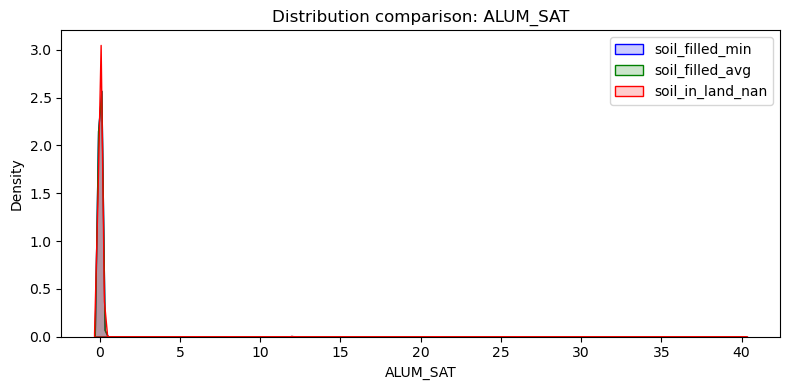

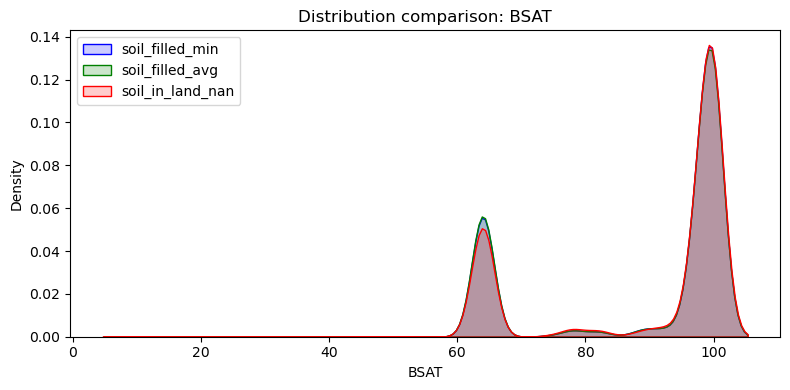

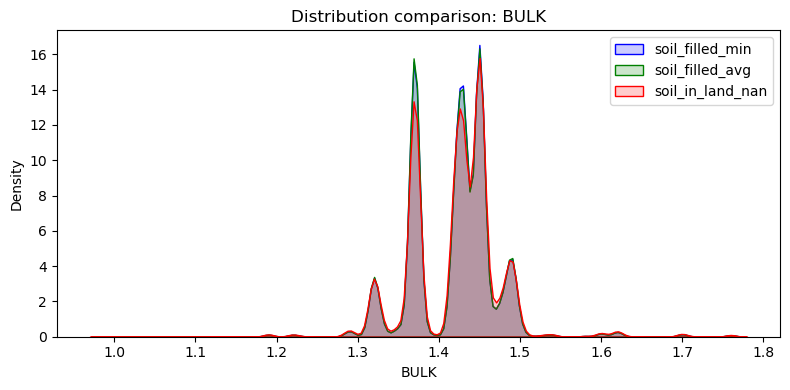

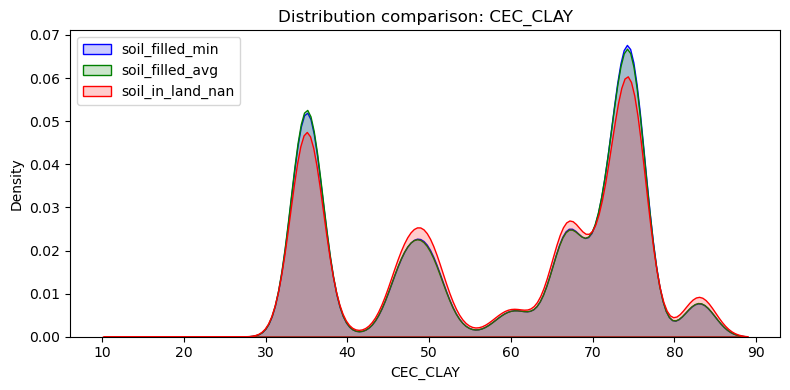

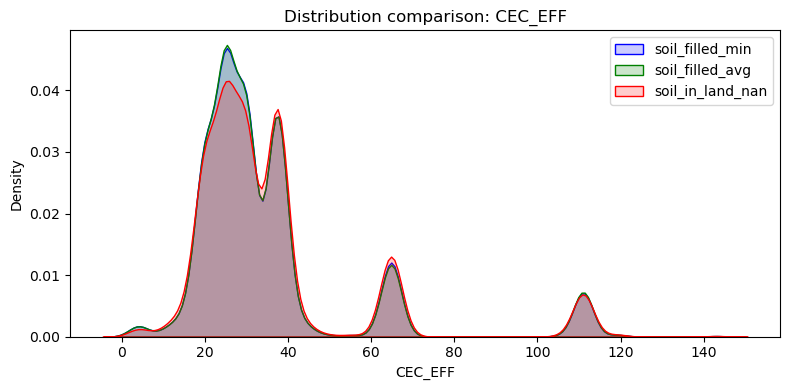

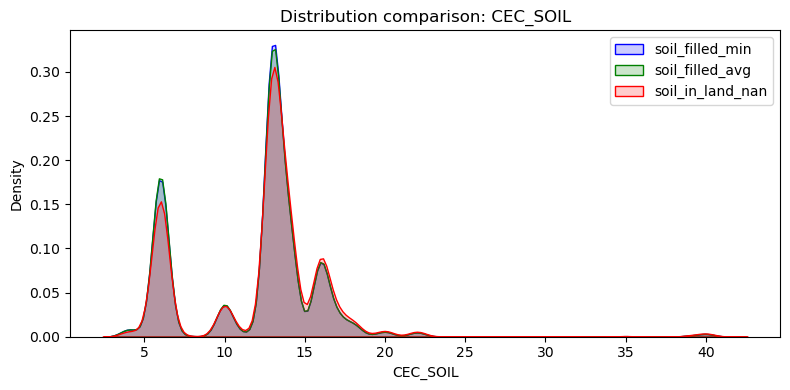

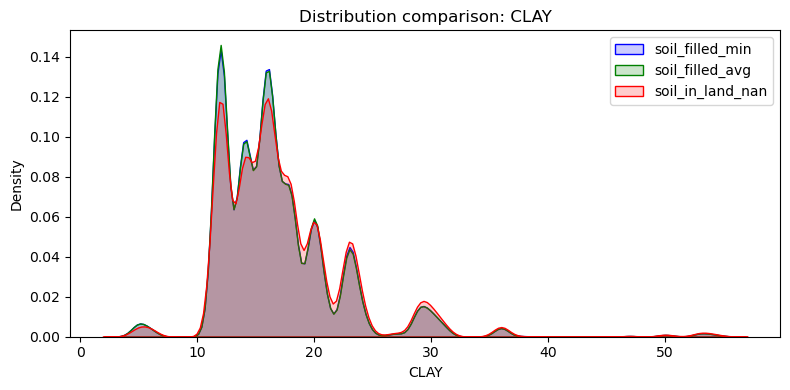

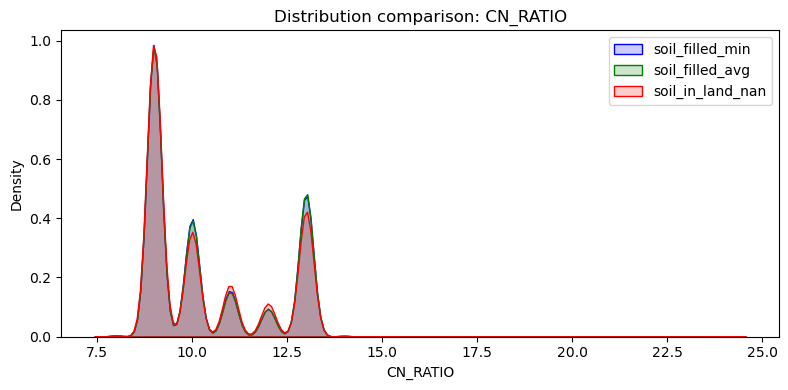

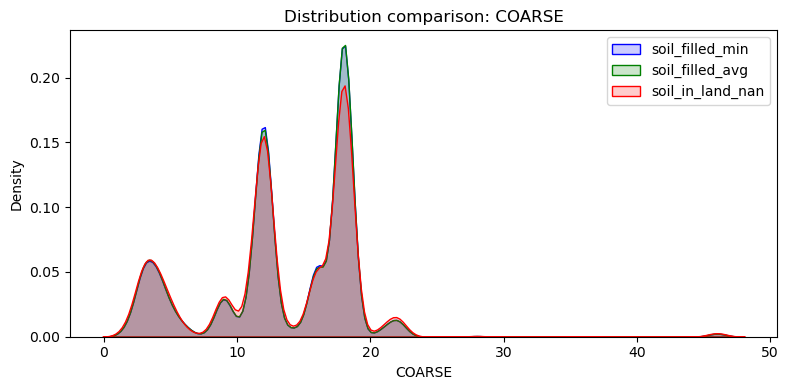

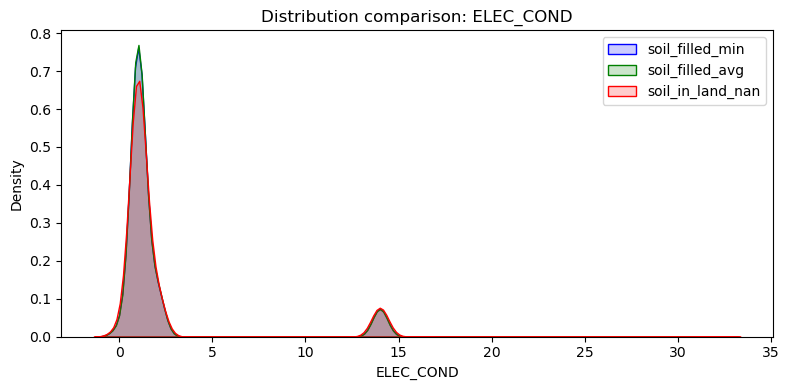

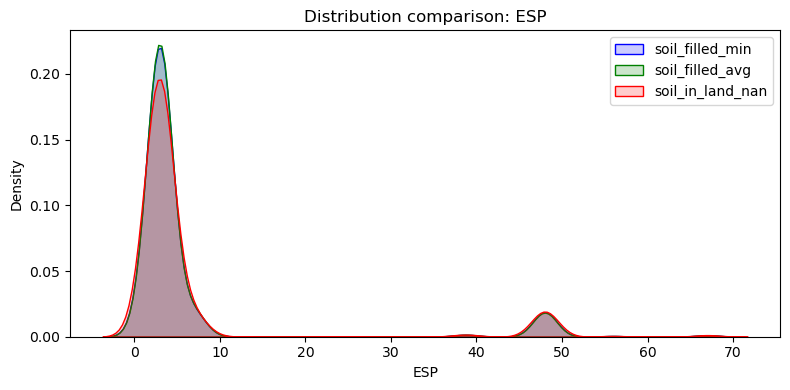

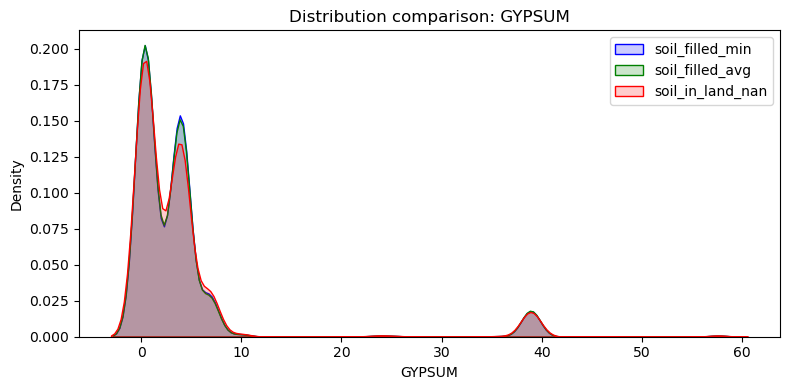

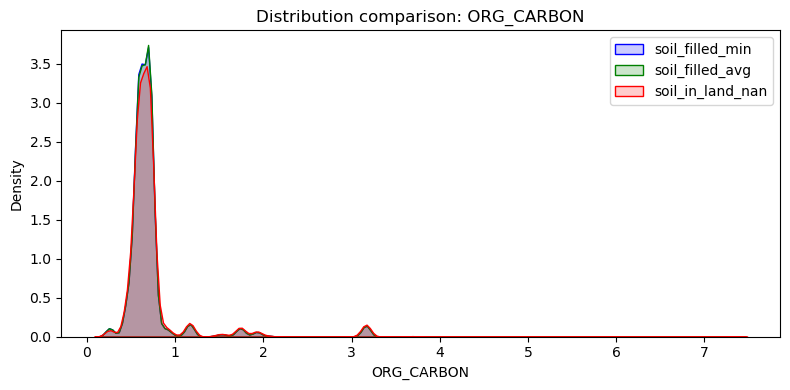

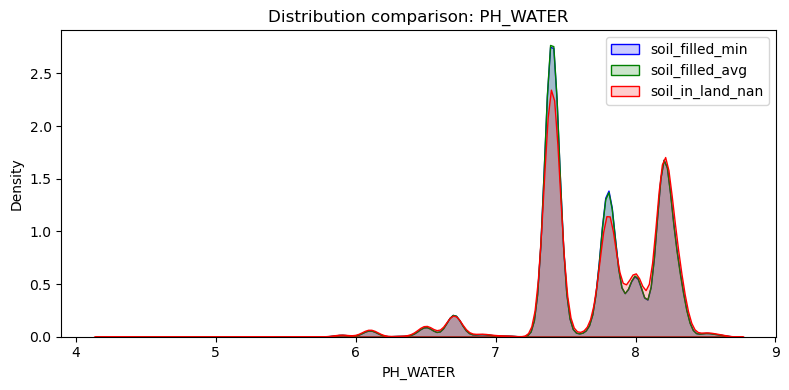

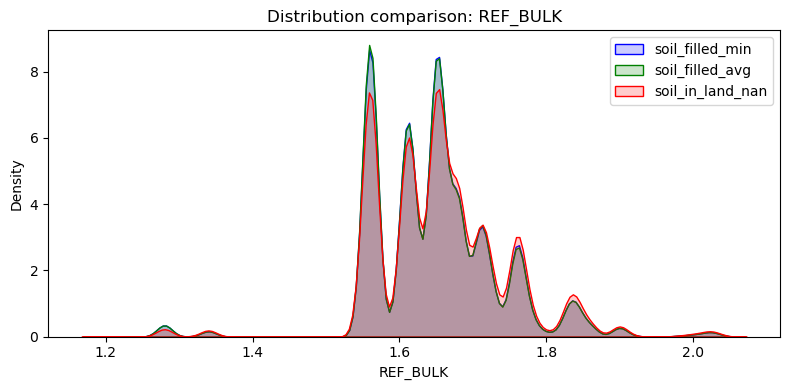

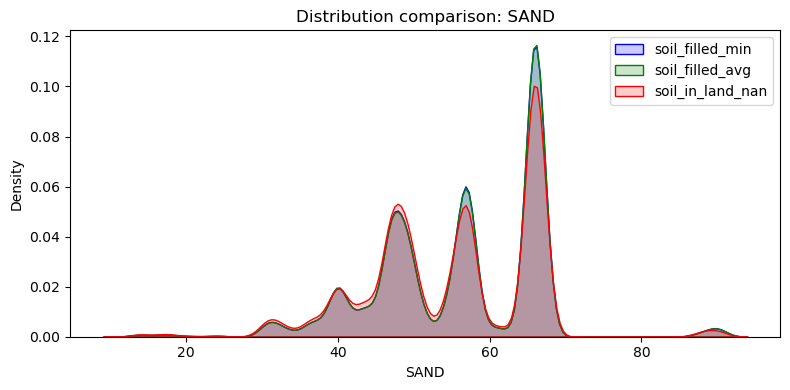

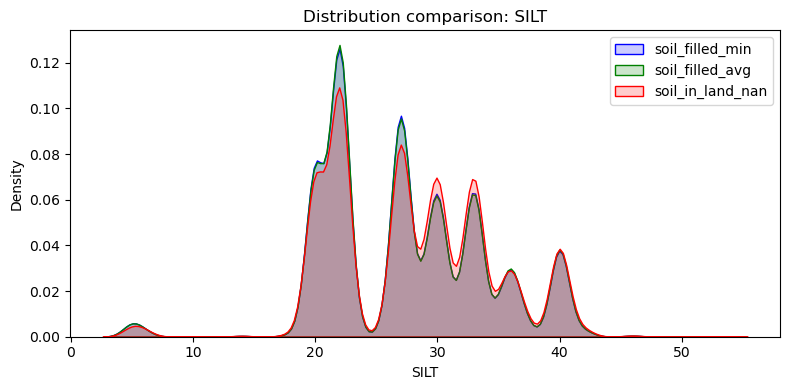

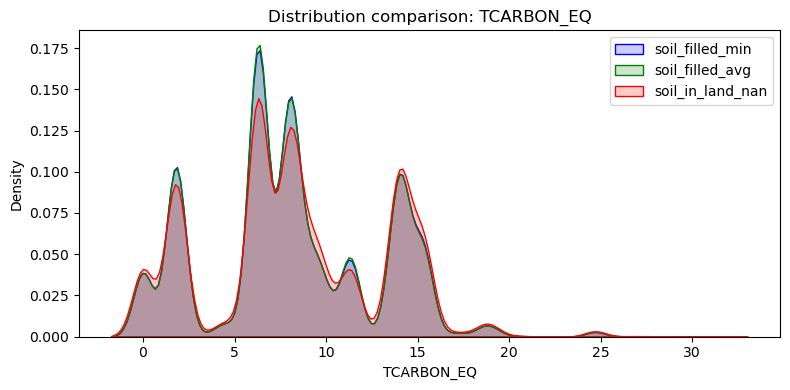

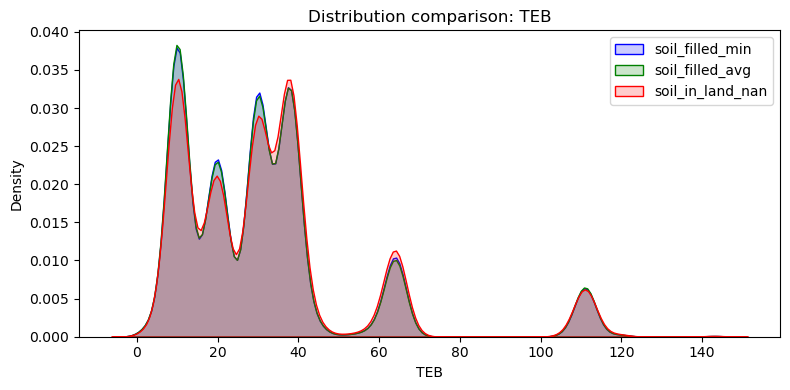

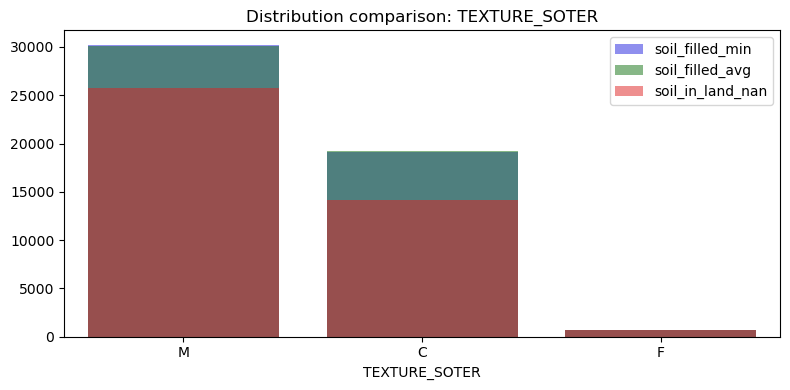

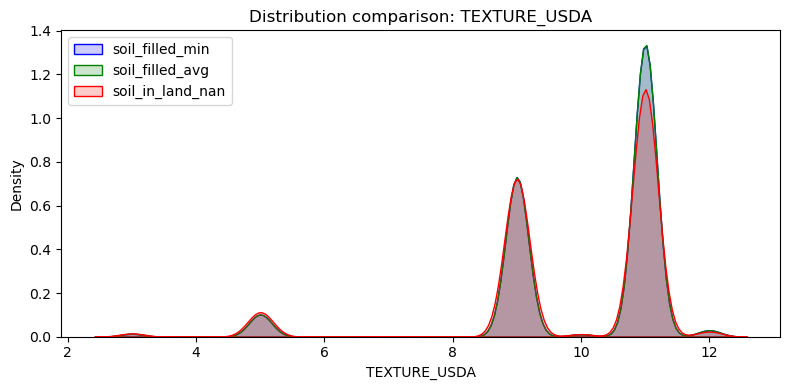

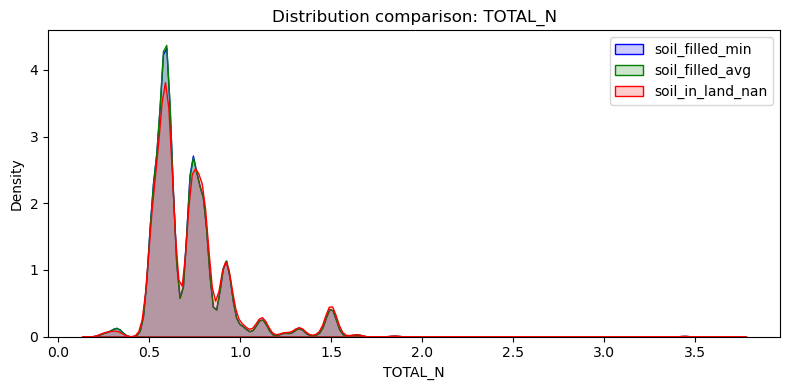

In [6]:
dfs = [
    ('soil_filled_min', soil_filled_min, 'blue'),
    ('soil_filled_avg', soil_filled_avg, 'green'),
    ('soil_in_land_nan', soil_in_land_nan, 'red')
]

compare_soil_distributions(dfs, cols=cols, save_path=Images_dir)


## avg vs min

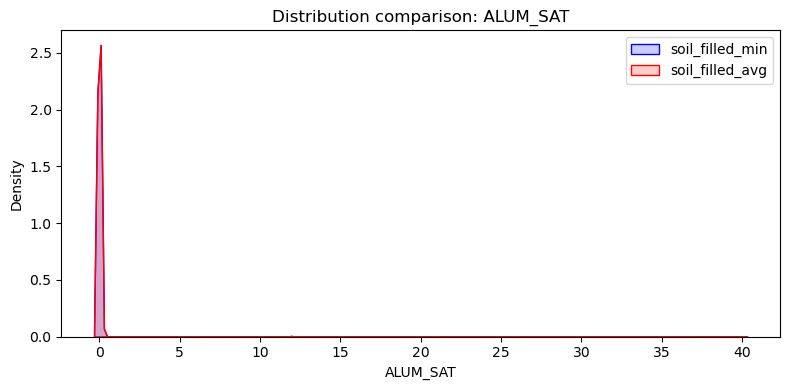

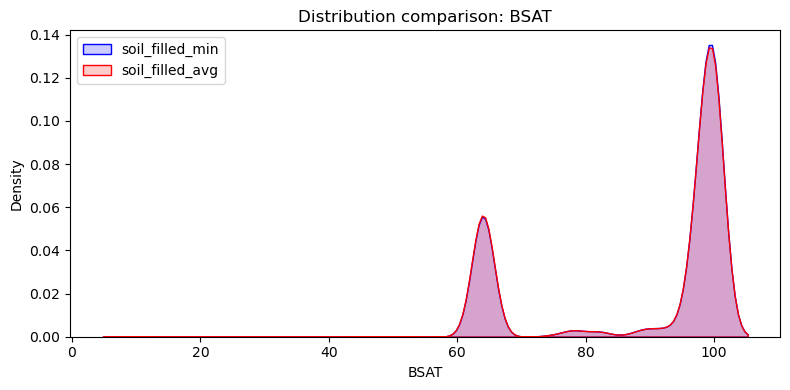

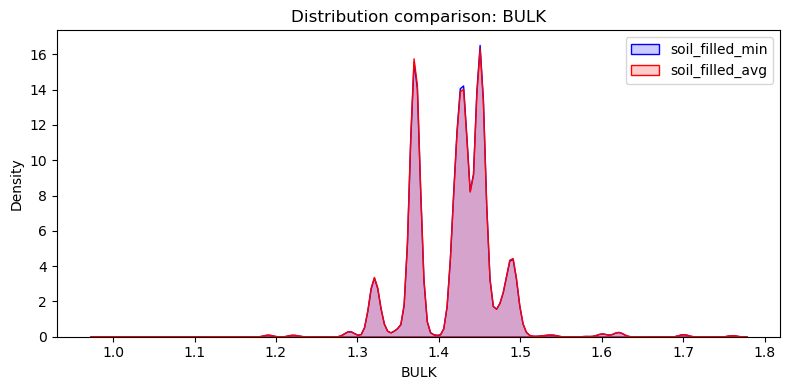

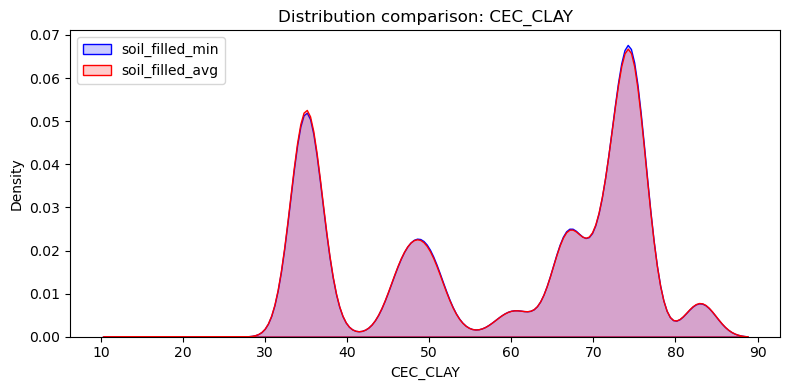

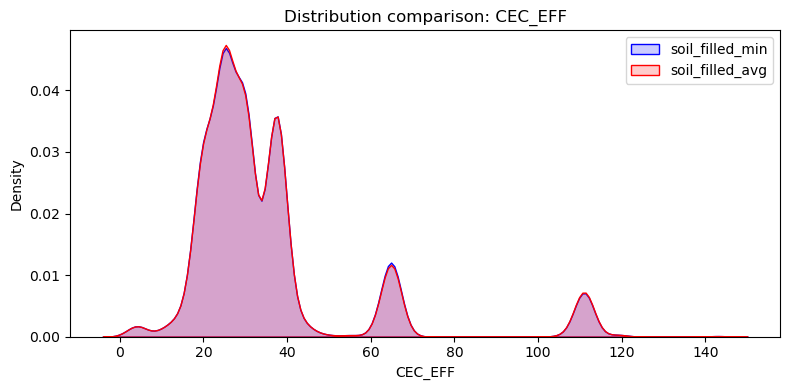

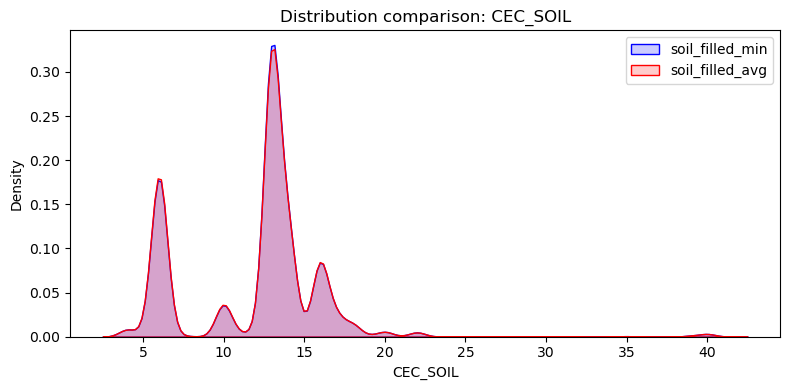

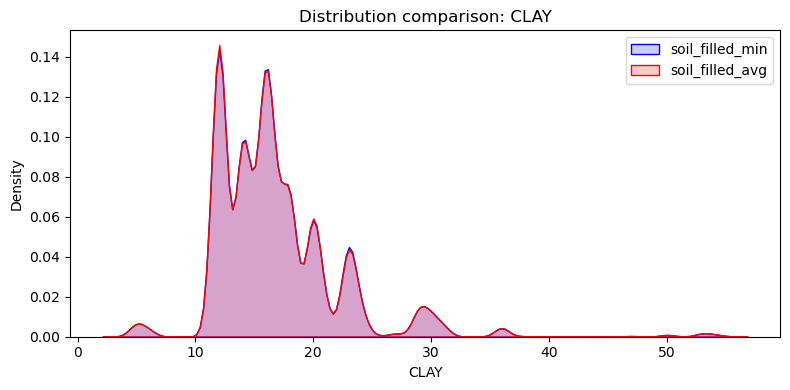

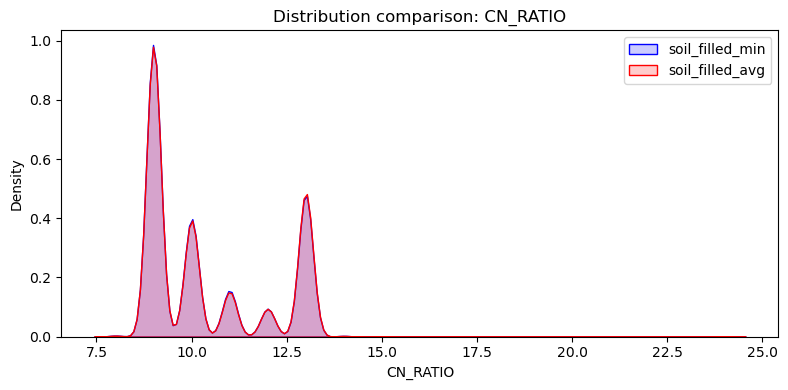

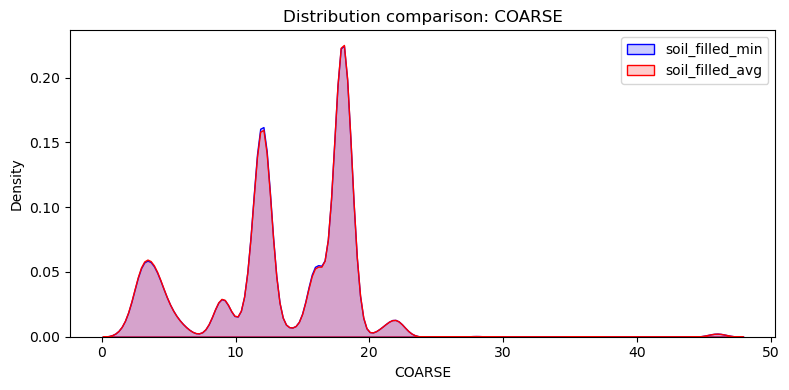

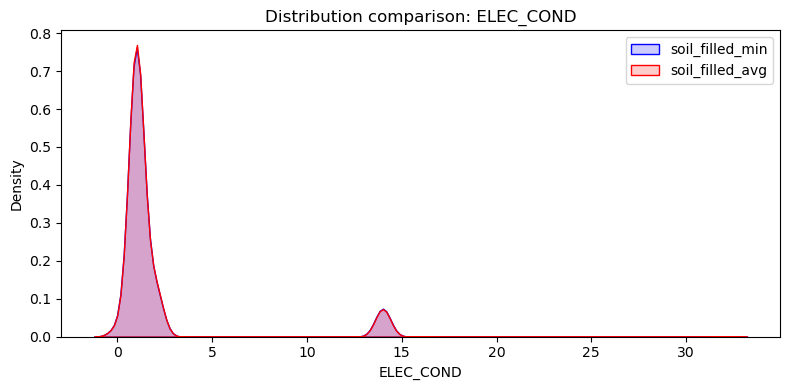

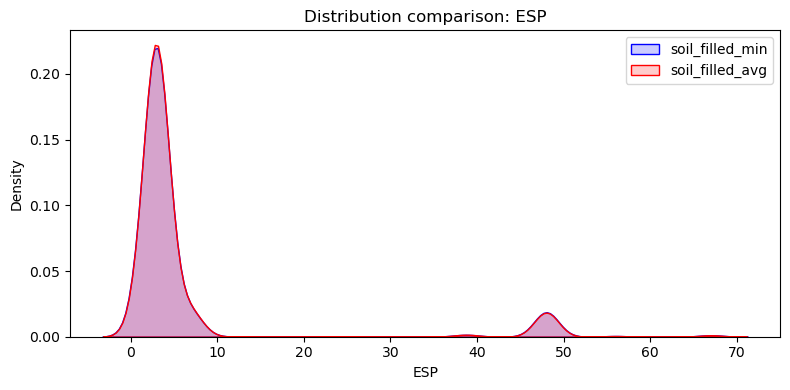

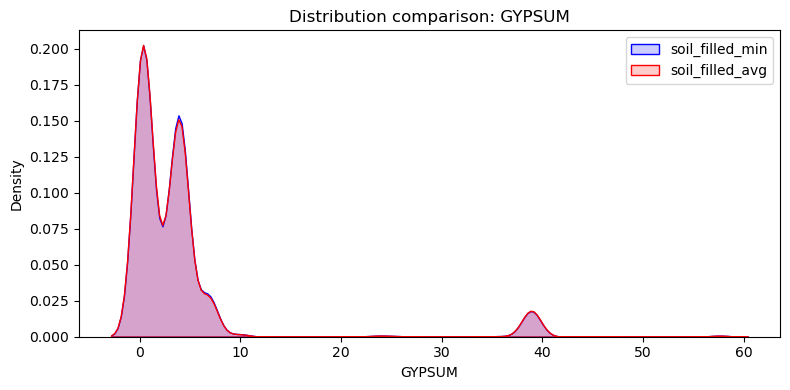

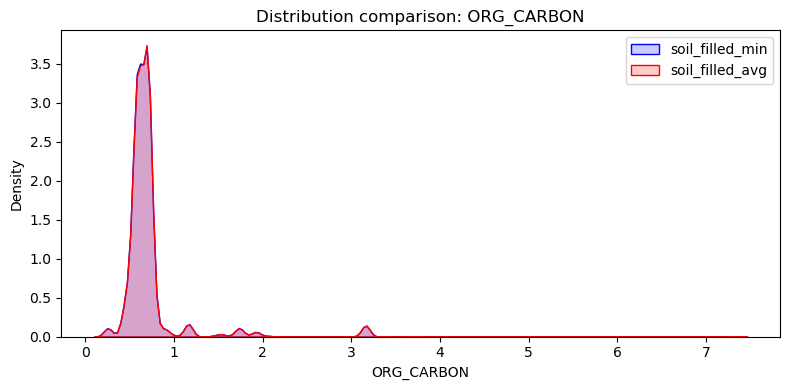

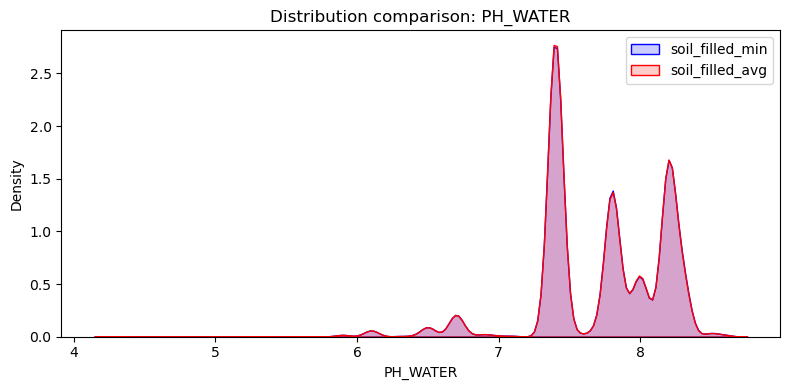

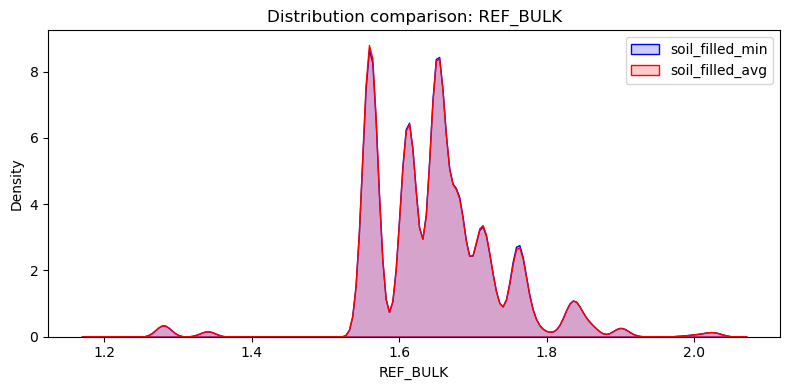

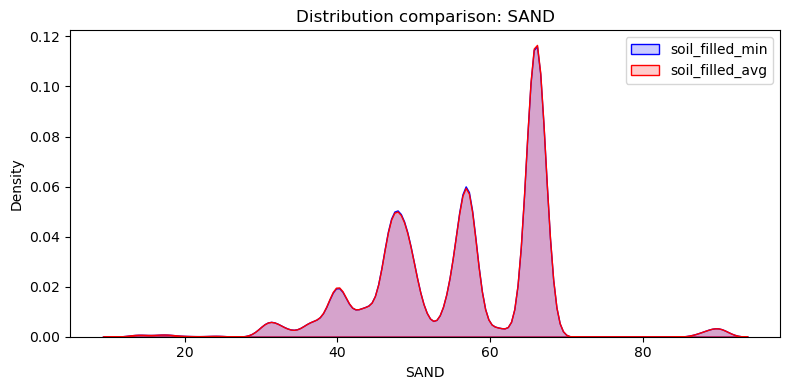

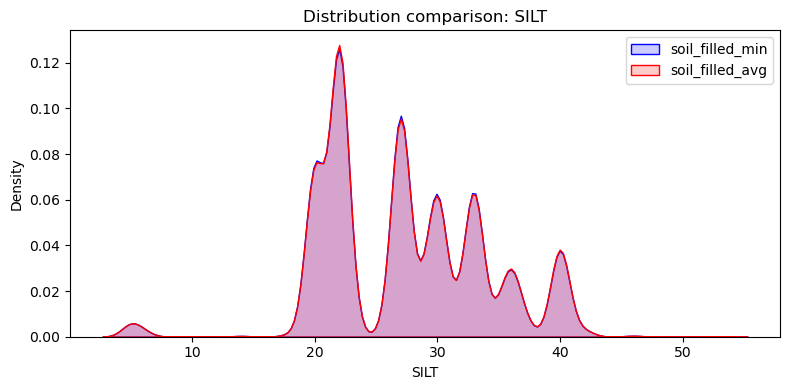

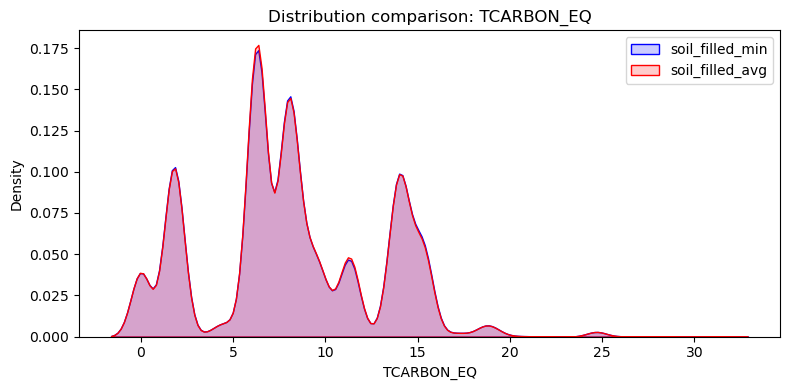

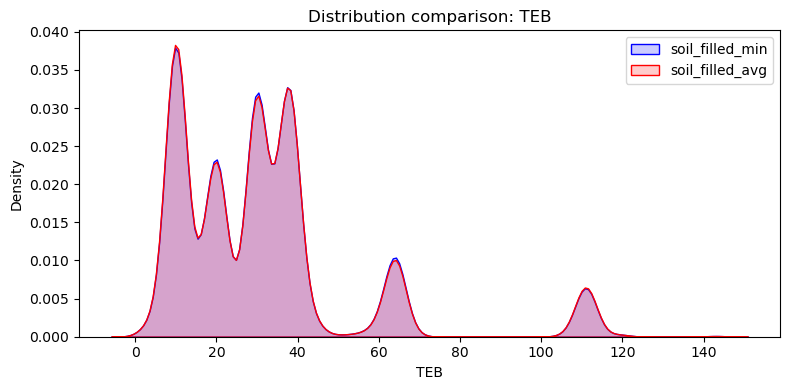

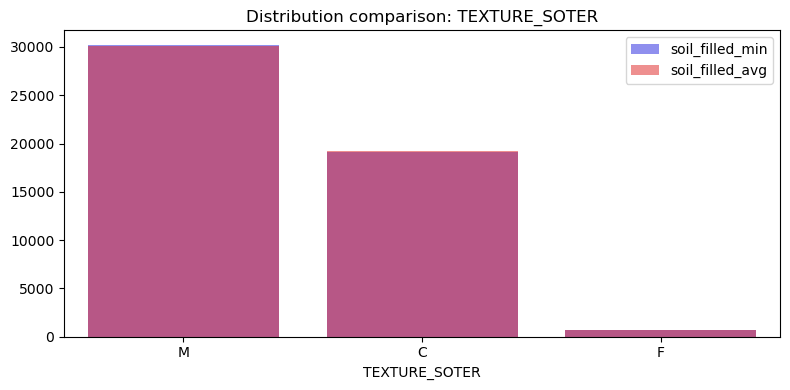

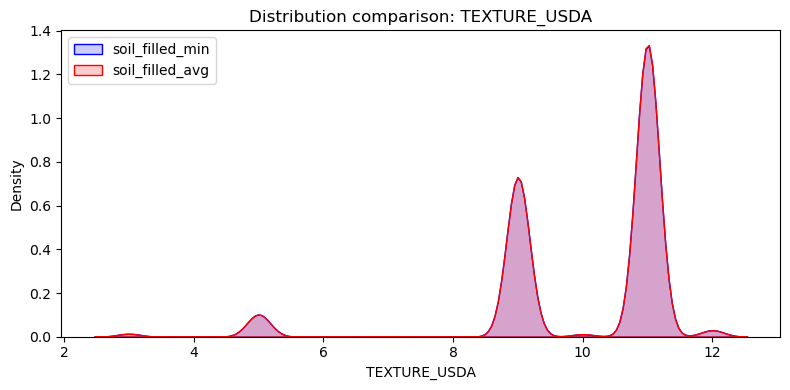

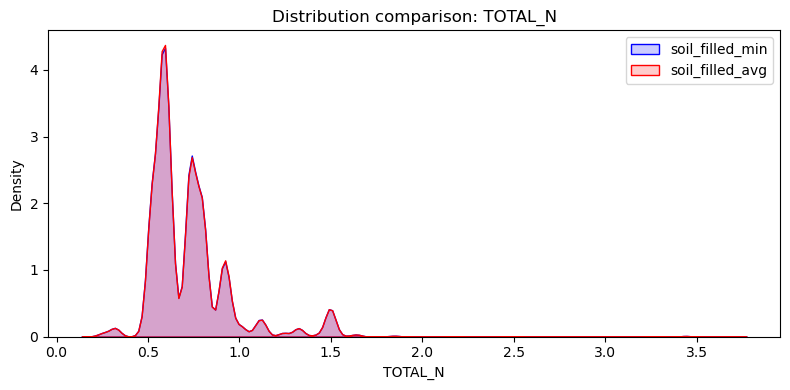

In [8]:
dfs = [
    ('soil_filled_min', soil_filled_min, 'blue'),
    ('soil_filled_avg', soil_filled_avg, 'red'),
    #('soil_in_land_nan', soil_in_land_nan, 'red')
]

compare_soil_distributions(dfs, cols=cols, save_path=Images_dir)


In [12]:
corr_nan = soil_in_land_nan.corr(method='spearman', numeric_only=True)
corr_min = soil_filled_min.corr(method='spearman', numeric_only=True)
corr_avg = soil_filled_avg.corr(method='spearman', numeric_only=True)

In [13]:
def corr_similarity(corr_ref, corr_other):
    mask = np.triu(np.ones(corr_ref.shape), k=1).astype(bool)
    ref_vals = corr_ref.values[mask]
    other_vals = corr_other.values[mask]
    return np.corrcoef(ref_vals, other_vals)[0, 1]

print("min vs nan:", corr_similarity(corr_nan, corr_min))
print("avg vs nan:", corr_similarity(corr_nan, corr_avg))


min vs nan: 0.9973272183367892
avg vs nan: 0.9971312996798957


In [14]:
def stats_diff(df_ref, df_other):
    ref = df_ref.describe()
    other = df_other.describe()
    diff = (other - ref).abs()
    return diff.loc[['mean', 'std']].mean(axis=1)

print("min vs nan:", stats_diff(soil_in_land_nan, soil_filled_min))
print("avg vs nan:", stats_diff(soil_in_land_nan, soil_filled_avg))

min vs nan: mean    0.264343
std     0.166478
dtype: float64
avg vs nan: mean    0.279301
std     0.162942
dtype: float64


In [15]:
from scipy.stats import ks_2samp

def mean_ks(df1, df2):
    common_cols = df1.select_dtypes('number').columns
    scores = []
    for c in common_cols:
        x1 = df1[c].dropna()
        x2 = df2[c].dropna()
        if len(x1) > 0 and len(x2) > 0:
            stat, _ = ks_2samp(x1, x2)
            scores.append(stat)
    return np.mean(scores)

print("KS min vs nan:", mean_ks(soil_in_land_nan, soil_filled_min))
print("KS avg vs nan:", mean_ks(soil_in_land_nan, soil_filled_avg))


KS min vs nan: 0.028848738602389398
KS avg vs nan: 0.029380617169264343


In [17]:
def imputation_rmse(df_ref, df_imp):
    mask = df_ref.notna()
    diffs = (df_ref[mask] - df_imp[mask]) ** 2
    return np.sqrt(diffs.mean().mean())

# calculate RMSE only for numeric columns
soil_in_land_nan_num = soil_in_land_nan.select_dtypes('number')
soil_filled_min_num = soil_filled_min.select_dtypes('number')
soil_filled_avg_num = soil_filled_avg.select_dtypes('number')
print("RMSE min vs nan:", imputation_rmse(soil_in_land_nan_num, soil_filled_min_num))
print("RMSE avg vs nan:", imputation_rmse(soil_in_land_nan_num, soil_filled_avg_num))

RMSE min vs nan: 0.0
RMSE avg vs nan: 0.0


In [18]:
def variance_ratio(df_ref, df_imp):
    ratio = df_imp.var() / df_ref.var()
    return ratio.mean()

print("Variance ratio min:", variance_ratio(soil_in_land_nan_num, soil_filled_min_num))
print("Variance ratio avg:", variance_ratio(soil_in_land_nan_num, soil_filled_avg_num))

Variance ratio min: 0.9410979310752551
Variance ratio avg: 0.9427932760537918


| Metric                           | min vs nan | avg vs nan | Interpretation                                       |
| -------------------------------- | ---------- | ---------- | ---------------------------------------------------- |
| **Correlation similarity**       | 0.9973     | 0.9971     | Both almost identical to original correlations       |
| **Mean diff**                    | 0.2643     | 0.2793     | Slightly less bias for min (closer to original mean) |
| **Std diff**                     | 0.1665     | 0.1629     | Practically same variability shift                   |
| **KS (distribution difference)** | 0.0288     | 0.0294     | Very small → distributions are preserved             |
| **RMSE (on non-missing)**        | 0.0        | 0.0        | Perfectly consistent with known data                 |
| **Variance ratio**               | 0.9411     | 0.9428     | Slight under-variance (expected with simple fill)    |

✅ **min** imputation wins very slightly:
- Smaller mean difference
- Slightly lower KS statistic
- Slightly closer correlation to original

In [22]:
# print corr min (of low triangle only) from most correlated (with abs value) to least
corr_min_vals = corr_min.where(np.tril(np.ones(corr_min.shape), k=-1).astype(bool))
corr_min_vals_stack = corr_min_vals.stack().reset_index()
corr_min_vals_stack['abs_corr'] = corr_min_vals_stack[0].abs()
corr_min_sorted = corr_min_vals_stack.sort_values(by='abs_corr', ascending=False)
for _, row in corr_min_sorted.iterrows():
    print(f"{row['level_0']} - {row['level_1']}: {row[0]:.4f}")

REF_BULK - CLAY: 0.9997
TCARBON_EQ - CEC_EFF: 0.9678
SILT - SAND: -0.9434
CLAY - SAND: -0.9398
REF_BULK - SAND: -0.9357
TCARBON_EQ - PH_WATER: 0.9234
CEC_EFF - PH_WATER: 0.9051
TEB - PH_WATER: 0.8968
TEB - CEC_EFF: 0.8945
TEXTURE_USDA - SAND: 0.8883
TEXTURE_USDA - CLAY: -0.8665
TCARBON_EQ - TEB: 0.8648
REF_BULK - TEXTURE_USDA: -0.8641
TOTAL_N - SILT: 0.8344
TOTAL_N - SAND: -0.8276
TEXTURE_USDA - SILT: -0.8265
CEC_SOIL - CLAY: 0.8103
CEC_SOIL - REF_BULK: 0.8091
CLAY - SILT: 0.8082
REF_BULK - SILT: 0.8027
TEB - SAND: -0.8024
CEC_EFF - SILT: 0.7896
TEB - CLAY: 0.7877
TEB - REF_BULK: 0.7827
CEC_SOIL - TOTAL_N: 0.7787
BSAT - TEB: 0.7773
TOTAL_N - REF_BULK: 0.7751
SILT - COARSE: -0.7751
TOTAL_N - CLAY: 0.7750
TCARBON_EQ - SILT: 0.7672
TEB - SILT: 0.7594
CEC_SOIL - SAND: -0.7566
SAND - COARSE: 0.7457
BSAT - CN_RATIO: -0.7442
CEC_EFF - SAND: -0.7339
ELEC_COND - ESP: 0.7328
CN_RATIO - COARSE: 0.7297
PH_WATER - SILT: 0.7241
GYPSUM - ORG_CARBON: -0.7239
TCARBON_EQ - SAND: -0.7185
PH_WATER - SAND:

In [23]:
soil_filled_min.columns

Index(['longitude', 'latitude', 'COARSE', 'SAND', 'SILT', 'CLAY',
       'TEXTURE_USDA', 'TEXTURE_SOTER', 'BULK', 'REF_BULK', 'ORG_CARBON',
       'PH_WATER', 'TOTAL_N', 'CN_RATIO', 'CEC_SOIL', 'CEC_CLAY', 'CEC_EFF',
       'TEB', 'BSAT', 'ALUM_SAT', 'ESP', 'TCARBON_EQ', 'GYPSUM', 'ELEC_COND',
       'geometry'],
      dtype='object')

In [28]:
import pandas as pd
import numpy as np

# Columns to keep
keep_cols_fire = ['longitude', 'latitude', 'COARSE', 'SAND', 'CLAY', 
 'TCARBON_EQ', 'PH_WATER', 'TOTAL_N', 'CN_RATIO', 'CEC_SOIL', 
 'ESP', 'GYPSUM']


soil_reduced = soil_filled_min[keep_cols_fire].copy()

# Correlation matrix (exclude lon/lat)
corr_matrix = soil_reduced.drop(columns=['longitude', 'latitude']).corr().abs()

# Mask diagonal using a boolean array
mask = np.eye(corr_matrix.shape[0], dtype=bool)  # True on diagonal
high_corr = (corr_matrix.where(~mask)  # invert mask
             .stack()
             .reset_index()
             .rename(columns={'level_0':'var1','level_1':'var2', 0:'corr'})
             .query('corr > 0.9'))

print("Columns kept:", keep_cols_fire)
print("\nHighly correlated pairs (>0.9):\n", high_corr)


Columns kept: ['longitude', 'latitude', 'COARSE', 'SAND', 'CLAY', 'TCARBON_EQ', 'PH_WATER', 'TOTAL_N', 'CN_RATIO', 'CEC_SOIL', 'ESP', 'GYPSUM']

Highly correlated pairs (>0.9):
 Empty DataFrame
Columns: [var1, var2, corr]
Index: []


| Attribute       | Kept / Dropped | Type        | Reasoning for Fire Classification                                                 |
| --------------- | -------------- | ----------- | --------------------------------------------------------------------------------- |
| `longitude`     | Kept           | Numeric     | Essential for spatial mapping of fire-prone areas.                                |
| `latitude`      | Kept           | Numeric     | Same as above; allows modeling geographic patterns.                               |
| `COARSE`        | Kept           | Numeric     | Represents rocks/pebbles, affects soil moisture and vegetation structure.         |
| `SAND`          | Kept           | Numeric     | Part of texture, influences water retention and fuel availability.                |
| `SILT`          | Dropped        | Numeric     | Highly correlated with `SAND` and `CLAY`, redundant.                              |
| `CLAY`          | Kept           | Numeric     | Key texture component, influences water retention and vegetation type.            |
| `TEXTURE_USDA`  | Dropped        | Categorical | Redundant since `SAND`, `CLAY`, `COARSE` already capture texture.                 |
| `TEXTURE_SOTER` | Dropped        | Categorical | Same reasoning as `TEXTURE_USDA`.                                                 |
| `BULK`          | Dropped        | Numeric     | Highly correlated with `CLAY` & `SAND`; redundant.                                |
| `REF_BULK`      | Dropped        | Numeric     | Correlated with `CLAY` & `SAND`; information preserved by kept columns.           |
| `ORG_CARBON`    | Dropped        | Numeric     | Related to `TCARBON_EQ`, redundant.                                               |
| `PH_WATER`      | Kept           | Numeric     | Influences vegetation growth, soil chemistry, indirectly affecting fire behavior. |
| `TOTAL_N`       | Kept           | Numeric     | Fertility proxy, biomass/fuel availability.                                       |
| `CN_RATIO`      | Kept           | Numeric     | Carbon/nitrogen ratio affects decomposition and fuel dynamics.                    |
| `CEC_SOIL`      | Kept           | Numeric     | Nutrient holding capacity affects plant growth and fuel load.                     |
| `CEC_CLAY`      | Dropped        | Numeric     | Highly correlated with `CEC_SOIL`; redundant.                                     |
| `CEC_EFF`       | Dropped        | Numeric     | Correlated with `CEC_SOIL` and `TEB`; redundant.                                  |
| `TEB`           | Dropped        | Numeric     | Correlated with `CEC_SOIL`; redundant.                                            |
| `BSAT`          | Dropped        | Numeric     | Base saturation less directly relevant to fire; correlated with `CEC_SOIL`.       |
| `ALUM_SAT`      | Dropped        | Numeric     | Less directly related to fire; correlated with other chemical properties.         |
| `ESP`           | Kept           | Numeric     | Sodium content influences vegetation stress and fuel characteristics.             |
| `TCARBON_EQ`    | Kept           | Numeric     | Total carbon content, indicator of organic matter/fuel load.                      |
| `GYPSUM`        | Kept           | Numeric     | Soil chemistry affects vegetation stress and growth.                              |
| `ELEC_COND`     | Dropped        | Numeric     | Correlated with `ESP` & `GYPSUM`; redundant.                                      |
| `geometry`      | Dropped        | Geometry    | Spatial info already captured by `longitude` & `latitude`.                        |


In [29]:
# shape of new soil_reduced dataframe
print("Soil reduced shape:", soil_reduced.shape)

Soil reduced shape: (7113954, 12)


In [30]:
soil_reduced.to_csv(os.path.join(processed_data_dir, 'soil_reduced.csv'), index=False)